# DIVAnd analysis using the sample data set

This example performs a salinity analysis using data from the Black Sea.     
The analysis is done for every season and year (using all data with 10-year sliding windows form the same season).

For testing purposes, let's start with a low resolution.

A slightly large test case:
* horizontal resolution of 0.1 degree for the Black Sea
* 51 depths levels
* 8 time instance
* fixed correlation length
* CPU time: 21 minutes
* CPU time increases linearly with the number of time instance.

In [1]:
using DIVAnd
using PyPlot
using NCDatasets
using DataStructures
using Dates
using Statistics

Download the file `Salinity.bigfile` (if it is not already present). It will be placed in the same directory as this notebook. This file based on the World Ocean Database.

In [2]:
fname = "data/Salinity.bigfile"

if !isfile(fname)
    download("https://dox.ulg.ac.be/index.php/s/k0f7FxA7l5FIgu9/download",fname)
else
    @info("Data file already downloaded")
end

┌ Info: Data file already downloaded
└ @ Main In[2]:6


Download the bathymetry if it is not already present

In [3]:
bathname = "data/gebco_30sec_16.nc"

if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

bathisglobal = true

┌ Info: Bathymetry file already downloaded
└ @ Main In[3]:6


true

Load the data which is here a simple text file with the following columns

| longitude | latitude | value | depth | flag | year | month | day | hour | time string | identifier | bottom depth |
|----------:|---------:|------:|------:|-------:|------:|-----:|-----|------:|-------:|-------:|-------:|
| 28.3333 | 43.167 | 15.7020 | 0.0 | 0 | 1991 | 09 | 03 | 16 | 1991-09-03T16:25 | Cruise:WOD05_BG000003-11570900-28.3333-43.167 | 36 | 
| 28.3333 | 43.167 | 15.7380 | 10.0 | 0 | 1991 | 09 | 03 | 16 | 1991-09-03T16:25 | Cruise:WOD05_BG000003-11570900-28.3333-43.167 | 36 |

Only longitude, latitude, depth, time and the values are used.

In [4]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadbigfile(fname);
@show size(obsval);

┌ Info: Loading data from 'big file' data/Salinity.bigfile
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/load_obs.jl:10


size(obsval) = (139230,)


The file contains about 140000 measurements.     
Print some basic statistics about the data. Keep an eye on the ranges.

In [5]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (27.1005, 41.65)
              minimum and maximum of obs. dimension 2: (40.517, 47.272)
              minimum and maximum of obs. dimension 3: (0.0, 2000.0)
              minimum and maximum of obs. dimension 4: (1977-03-27T04:00:00, 2006-12-15T09:52:00)
                          minimum and maximum of data: (0.0, 38.6573)


┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/obsstat.jl:75


Define the resolution. It is recommended to start with a low resolution and increase the resolution when the results are suitable.

In [6]:
dx = 0.2 # longitude resolution in degrees
dy = 0.2 # latitude resolution in degrees

0.2

Define bounding box spatial domain

In [7]:
lonr = 27.:dx:42.; # the range of longitudes (start:step:end)
latr = 40.:dy:47.; # the range of latitudes (start:step:end)

Define the depth levels

In [8]:
depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000]

# or for testing just a few levels
depthr = [0.,20.,50.]

@show size(depthr);

size(depthr) = (3,)


The error variance of the observation (scaled by the error variance of the background).    
Note that this is the inverse of the signal-to-noise ratio used in the 2D version of `DIVA`.

In [9]:
epsilon2 = 0.01

0.01

* Correlation length in meters (in x, y, and z directions)
* 200_000. is the same as 200000., but the former is easier to read.

In [10]:
sz = (length(lonr),length(latr),length(depthr))

lenx = fill(200_000.,sz)
leny = fill(200_000.,sz)
lenz = [10+depthr[k]/15 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]];

Year range and averaging time window

In [11]:
years = 1993:1994

year_window = 10

# winter: January-March    1,2,3
# spring: April-June       4,5,6
# summer: July-September   7,8,9
# autumn: October-December 10,11,12

monthlists = [
    [1,2,3],
    [4,5,6],
    [7,8,9],
    [10,11,12]
];

* Other possible choises for the time selector are `TimeSelectorYearListMonthList` and `TimeSelectorRunningAverage`.
* Type `?` followed by these functions

In [12]:
?TimeSelectorYW

search: TimeSelectorYW TimeSelectorYearListMonthList TimeSelectorRunningAverage



```
TS = TimeSelectorYW(years,yearwindow,monthlists)
```

The structure `TS` handles the time aggregation based on `years` and `monthlists`. It is similar to `TimeSelectorYearListMonthList` except that the elements of `yearlists` are centred around `years` and span `yearwindow` years. `yearlists` is in fact constructed by adding and subtracting `yearwindow/2` to every element of years.


In [13]:
TS = TimeSelectorYW(years,year_window,monthlists)

varname = "Salinity"

# File name based on the variable (but all spaces are replaced by _)
filename = "Water_body_$(replace(varname, " "=>"_")).4Danl.nc"

# Time origin for the NetCDF file
timeorigin = DateTime(1900,1,1,0,0,0)

# Extract the bathymetry for plotting
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);

A list of all metadata

In [14]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet/EMODNet Chemistry Data Network",

    # Additional comment
    "comment" => "...",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",
    
    "product_code" => "something-to-decide",
    
    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # https://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/
        
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",

    "netcdf_long_name" => "sea water salinity",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "https://doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...")

OrderedDict{String,Any} with 18 entries:
  "project"               => "SeaDataCloud"
  "institution_urn"       => "SDN:EDMO::1579"
  "Author_e-mail"         => ["Your Name1 <name1@example.com>", "Other Name <na…
  "source"                => "observational data from SeaDataNet/EMODNet Chemis…
  "comment"               => "..."
  "parameter_keyword_urn" => "SDN:P35::EPC00001"
  "search_keywords_urn"   => ["SDN:P02::PSAL"]
  "area_keywords_urn"     => ["SDN:C19::3_3"]
  "product_version"       => "1.0"
  "product_code"          => "something-to-decide"
  "bathymetry_source"     => "The GEBCO Digital Atlas published by the British …
  "netcdf_standard_name"  => "sea_water_salinity"
  "netcdf_long_name"      => "sea water salinity"
  "netcdf_units"          => "1e-3"
  "abstract"              => "..."
  "acknowledgement"       => "..."
  "documentation"         => "https://doi.org/doi_of_doc"
  "doi"                   => "..."

* Make the NetCDF global and variable attributes based on the metadata.
* Custom attributes can be added by changing `ncglobalattrib`:

```julia
ncglobalattrib["attribute_name"] = "attribute_value"
```


In [15]:
ncglobalattrib,ncvarattrib = SDNMetadata(metadata,filename,varname,lonr,latr)

(OrderedDict("project"=>"SeaDataCloud","institution"=>"University of Liege, GeoHydrodynamics and Environment Research","institution_urn"=>"SDN:EDMO::1579","Author_e-mail"=>"Your Name1 <name1@example.com>, Other Name <name2@example.com>","source"=>"observational data from SeaDataNet/EMODNet Chemistry Data Network","comment"=>"...","parameter_keyword"=>"Water body salinity","parameter_keyword_urn"=>"SDN:P35::EPC00001","search_keywords"=>"Salinity of the water column","search_keywords_urn"=>"SDN:P02::PSAL"…), OrderedDict("units"=>"1e-3","standard_name"=>"sea_water_salinity","long_name"=>"sea water salinity"))

Plot the results near the surface for debugging and quick inspection.

To generate the plots, we define a function `plotres` (see next cell) that will be used as an optional argument when we call the interpolation with `DIVAnd`.

In [16]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    tmp[erri .> .5] .= NaN;
    figure(figsize = (10,8))
    subplot(2,1,1)
    title("$(timeindex)")
    
    # select the data near the surface
    selsurface = sel .& (obsdepth .< 5)
    vmin = minimum(obsval[selsurface])
    vmax = maximum(obsval[selsurface])
    
    # plot the data
    scatter(obslon[selsurface],obslat[selsurface],10,obsval[selsurface];
            vmin = vmin, vmax = vmax)
    xlim(minimum(lonr),maximum(lonr))
    ylim(minimum(latr),maximum(latr))
    colorbar()
    contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
    
    # plot the analysis
    subplot(2,1,2)
    pcolor(lonr,latr,permutedims(tmp[:,:,1],[2,1]);
           vmin = vmin, vmax = vmax)
    colorbar()
    contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
end

plotres (generic function with 1 method)

If you do not want to generate plots but print the time index at every time slice
you can use the function `plotres_timeindex`.

In [17]:
function plotres_timeindex(timeindex,sel,fit,erri)
    @show timeindex
end

plotres_timeindex (generic function with 1 method)

Launch the analysis. Plotting can be disabled by commenting the line containing `plotres`.

Here we use `diva3d`, which performs a series of 3D analyses (lon, lat and depth) for the different periods defined previously.

In [18]:
?diva3d

search: diva3d DIVAnd_filter3



```
dbinfo = diva3d(xi,x,value,len,epsilon2,filename,varname)
```

Create a 3D analysis (or a series of 3D analyses) with DIVAnd using the observations `value` (vector) at the locations `x` (tuple of vectors) onto the regular grid defined by the vectors `xi` using the scaled observational error variance  `epsilon2` and the correlation length `len`. The result will be saved in the NetCDF file `filename` under the variable `varname`.

## Inputs

  * `xi`: tuple with n elements. Every element represents a coordinate of the final grid on which the observations are interpolated
  * `x`: tuple with n elements. Every element represents a coordinate of the observations
  * `value`: value of the observations
  * `len`: tuple with n elements. Every element represents the correlation length.  If `fitcorrlen` is `false` (default), the correlation length should be expressed in meters.  If `fitcorrlen` is `true`, then `len` can be the empty tuple `()` or a tuple containing  3 arrays of normalized correlation lengths which will be multiplied by the  horizontal and vertical correlation lengths.
  * `epsilon2`: error variance of the observations (normalized by the error variance of the background field). `epsilon2` can be a scalar (all observations have the same error variance and their errors are decorrelated), a vector (all observations can have a different error variance and their errors are decorrelated) or a matrix (all observations can have a different error variance and their errors can be correlated). If `epsilon2` is a scalar, it is thus the *inverse of the signal-to-noise ratio*.
  * `filename`: The output NetCDF filename.
  * `varname`: The name of the variable (used in the NetCDF file).

## Optional input arguments:

  * `bathname`: path to the NetCDF bathymetry (default ../../DIVAnd-example-data/Global/Bathymetry/gebco*30sec*16.nc relative to this source file)
  * `bathisglobal`: true (default) is the bathymetry is a global data set
  * `plotres`: Call-back routine for plotting ((timeindex,sel,fit,erri) -> nothing)
  * `timeorigin`: Time origin (default DateTime(1900,1,1,0,0,0))
  * `moddim`: modulo for cyclic dimension (vector with n elements).    Zero is used for non-cyclic dimensions. Halo points should    not be included for cyclic dimensions. For example if the first dimension    is cyclic, then the grid point corresponding to `mask[1,j]` should be    between `mask[end,1]` (left neighbor) and `mask[2,j]` (right neighbor). The default is [0,0,0],
  * `zlevel`: `:surface` (default) for surface analysis and `:floor` for analysis from the bottom floor.
  * `ncvarattrib`: dictionary of NetCDF variable attributes.
  * `ncglobalattrib`: dictionary of NetCDF global attributes.
  * `transform`: Anamorphosis transformation function (default: `Anam.notransform()`).
  * `fitcorrlen`: true if the correlation length is determined from the observation (default `false`).    Note that the parameter `len` is interpreted differently when `fitcorrlen` is set to `true`.
  * `fithorzcorrlen`: true if the horizontal correlation length is determined from the observation (default: the value of `fitcorrlen`)    Note that the parameter `len` is interpreted differently when `fithorzcorrlen` is set to `true`.
  * `fitvertcorrlen`: true if the vertical correlation length is determined from the observation (default: the value of `fitcorrlen`)    Note that the parameter `len` is interpreted differently when `fitvertcorrlen` is set to `true`.
  * `fithorz_param`: dictionary with additional optional parameters for `fithorzlen`, for example: `Dict(:smoothz => 200., :searchz => 50.)`.
  * `fitvert_param`: dictionary with additional optional parameters for `fitvertlen`.
  * `distfun`: function to compute the distance (default `(xi,xj) -> DIVAnd.distance(xi[2],xi[1],xj[2],xj[1])`).
  * `mask`: if different from `nothing`, then this mask overrides land-sea mask based on the bathymetry

(default `nothing`).

  * `background`: if different from `nothing`, then this parameter allows one

to load the background from a call-back function (default `nothing`). The call-back functions has the parameters `(x,n,trans_value,trans)` where `x` represent the position of the observations, `n` the time index, `trans_value`, the observations (possibly transformed) and `trans` the transformation function. The output of this function is the gridded background field and the observations minus the background field.

  * `background_espilon2_factor`: multiplication for `epsilon2` when computing a  vertical profile as a background estimate (default 10.). This parameter is not used  when the parameter `background` is provided.
  * `background_lenz`: vertical correlation for background computation (default 20 m). This parameter is not used  when the parameter `background` is provided.
  * `background_len`: deprecated option replaced by `background_lenz`.
  * `memtofit`: keyword controlling how to cut the domain depending on the memory   remaining available for inversion. It is not total memory (default 3). Use a large value (e.g. 100) to force the   usage for the more efficient direct solver if you are not limited by the amount of RAM memory.
  * `minfield`: if the analysed field is below `minfield`, its value is replace by `minfield` (default -Inf, i.e. no substitution is done).
  * `maxfield`: if the analysed field is above `maxfield`, its value is replace by `maxfield` (default +Inf, i.e. no substitution is done).
  * `saveindex`: controls if just a subset of the analysis should be saved to   the netCDF file. Per default, `saveindex` is `(:,:,:)` (corresponding to   longitude, latitude and depth indices) meaning that everything is saved.   If however, for example the first layer should not be saved then `saveindex`   should be `(:,:,2:length(depthr))` where `depthr` is the 3rd element of `xi`.
  * `niter_e`: Number of iterations to estimate the optimal scale factor of  `epsilon2` using Desroziers et al. 2005 (doi: 10.1256/qj.05.108). The default   is 1 (i.e. no optimization is done).

Any additional keywoard arguments understood by `DIVAndgo` can also be used here (e.g. velocity constrain)

The output is a dictionary with the followings keys:

  * `:residuals`: the difference between the analysis (interpolated linearly to the

location of the observation) and the observations. The residual is NaN is the observations are not with in the domain as defined by the mask and the coordinates of the observations `x`.

  * `:qcvalues`: quality control scores (if activated)


┌ Info: Creating netCDF file
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:304
┌ Info: Time step 1 / 8
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:341
┌ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:486
┌ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:486
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:486
┌ Warning: resolution (20.0) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(4, 3, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/utils.jl:14
┌ Info: number of windows: 1
└ @ DIVAnd /home/abarth/projects/Julia/

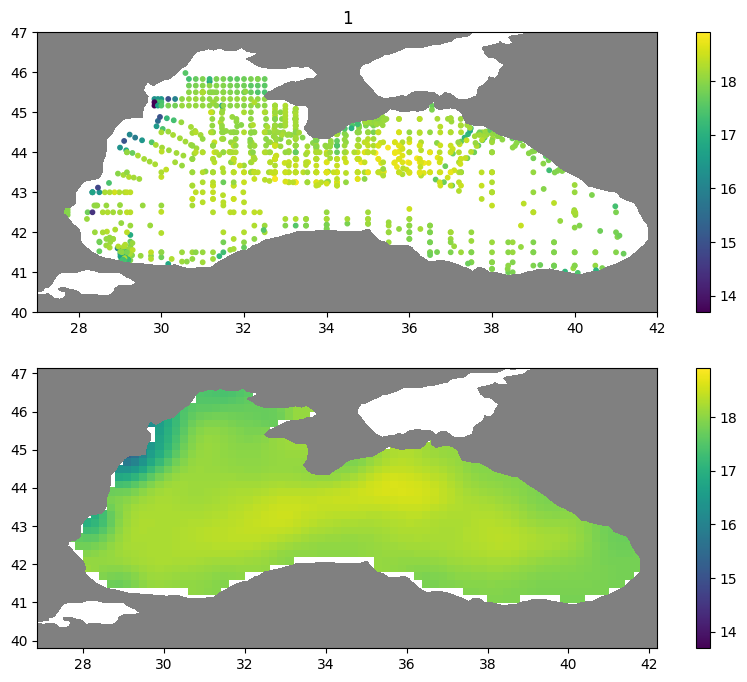

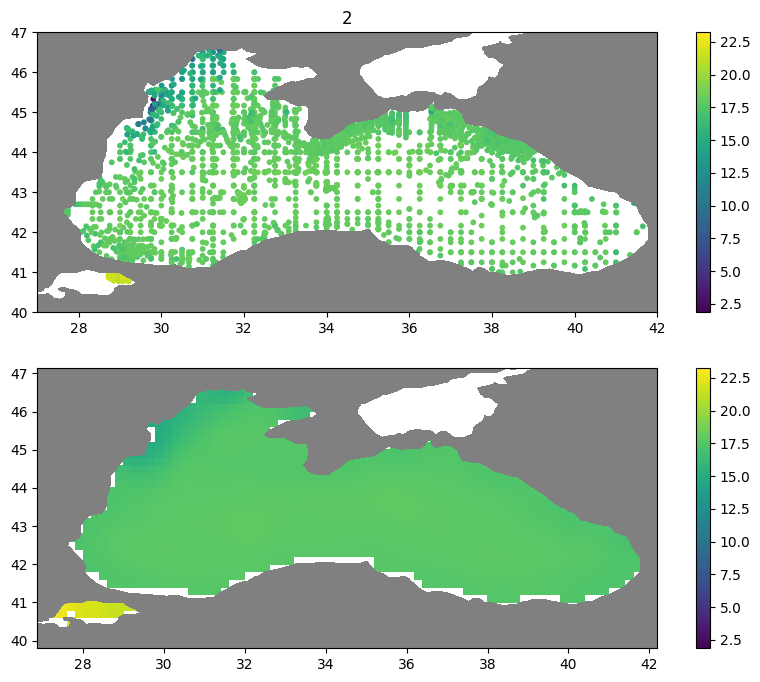

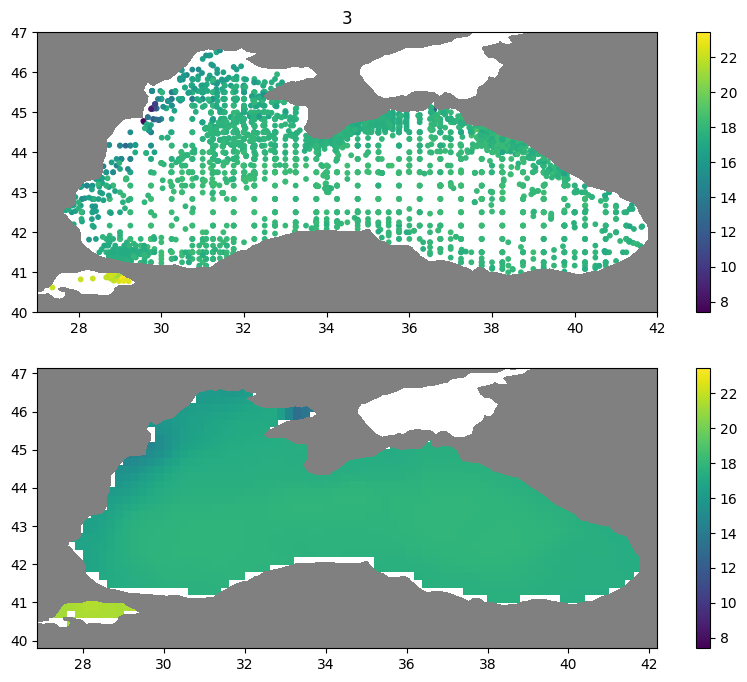

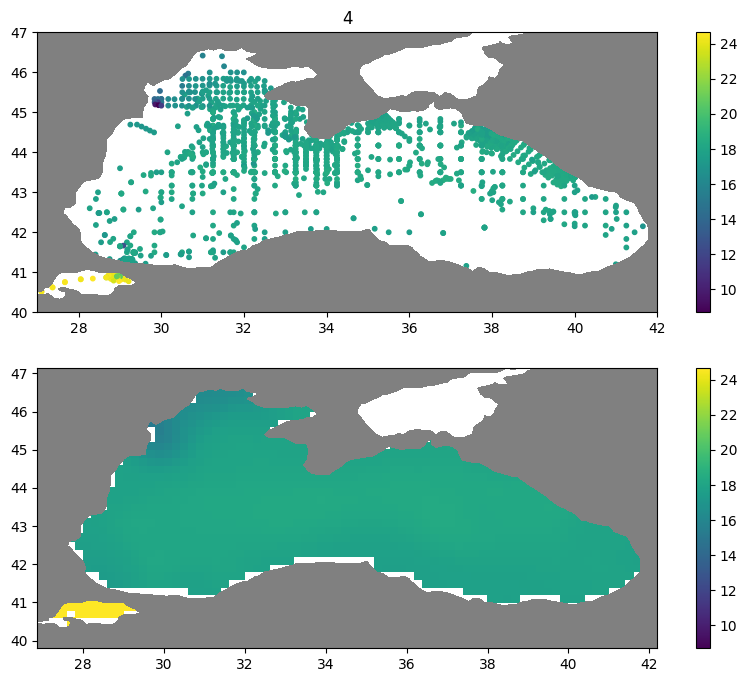

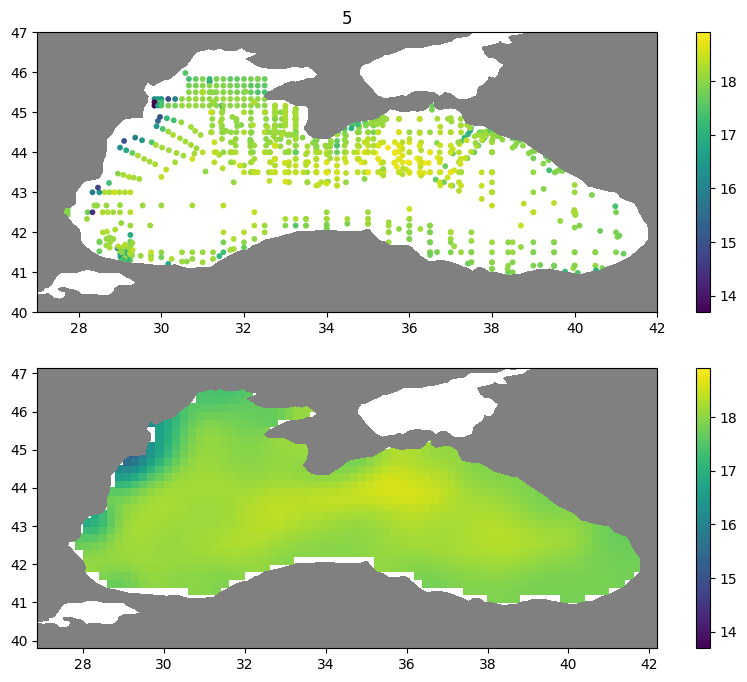

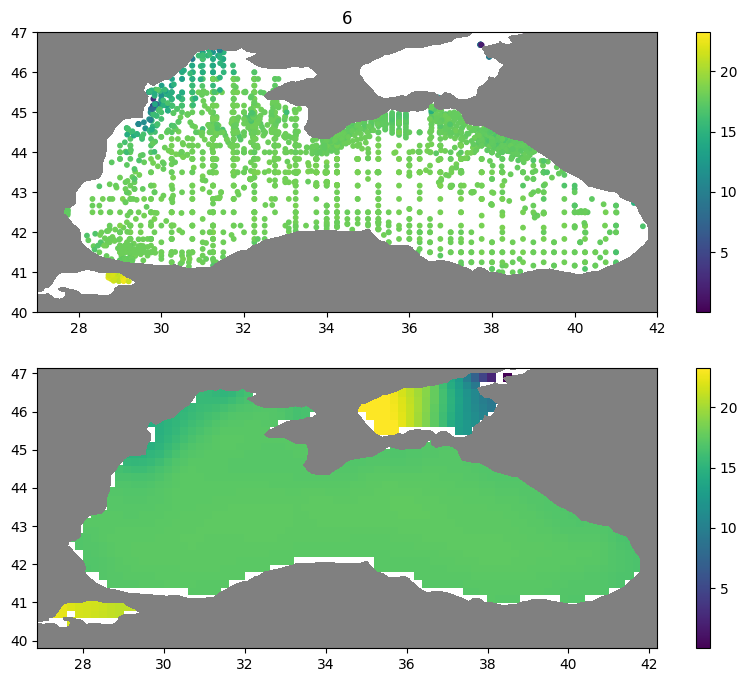

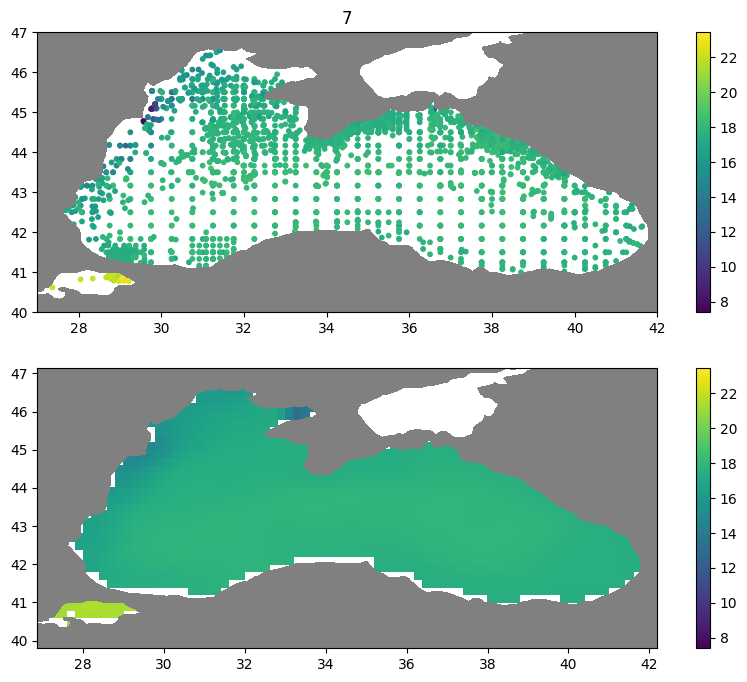

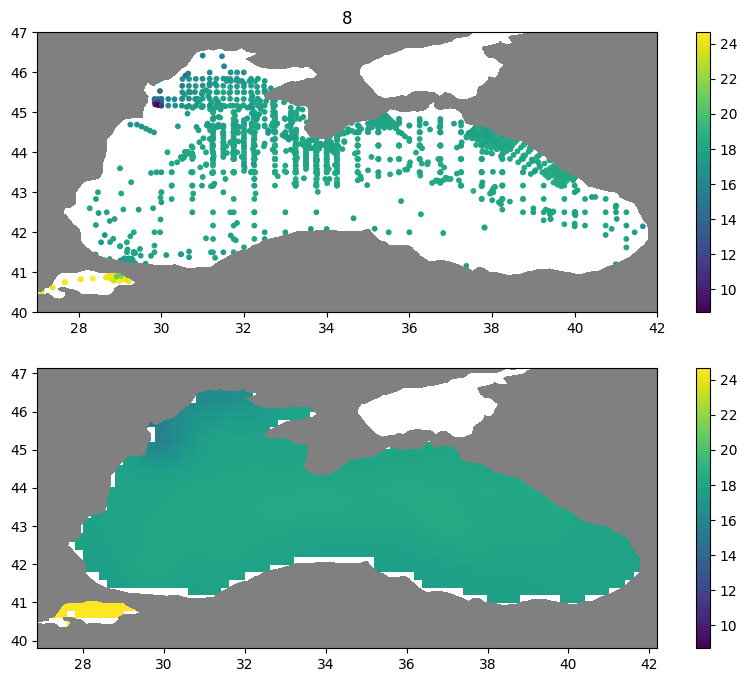

 42.579877 seconds (150.83 M allocations: 9.750 GiB, 9.86% gc time)


In [19]:
if isfile(filename)
   rm(filename) # delete the previous analysis
end

@time dbinfo = diva3d((lonr,latr,depthr,TS),
              (obslon,obslat,obsdepth,obstime),
              obsval,
              (lenx,leny,lenz),
              epsilon2,
              filename,varname,
              bathname = bathname,
              bathisglobal = bathisglobal,
              plotres = plotres,
              ncvarattrib = ncvarattrib,
              ncglobalattrib = ncglobalattrib,
              timeorigin = timeorigin
       );


residual = dbinfo[:residuals];

This generates many plots (one for every time instance).     
The number in the title is the time index starting with the first season and year.


Save the observation metadata in the NetCDF file

In [20]:
DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid)

# Residuals

Range of the residuals

In [21]:
res = get(dbinfo, :residuals, 0)
@show extrema(res);

extrema(res) = (NaN, NaN)


Residuals with NaNs removed

In [22]:
res = residual[.!isnan.(residual)]

@show extrema(res);
@show quantile(res,[0.01,0.99]);

extrema(res) = (-10.424041748046875, 15.84592056274414)
quantile(res, [0.01, 0.99]) = [-0.906637, 0.748023]


Get the identifier of the anomalous point

In [23]:
i = findfirst(minimum(res) .== residual)
obsid[i]

"Cruise:WOD05_UA000106-11577843-29.7960-45.147"

For future analysis the residuals can also be saved.

In [24]:
resname = filename = "data/Water_body_$(replace(varname, " "=>"_")).residuals.nc"

if isfile(resname)
   rm(resname)
end
DIVAnd.saveobs(resname,"$(varname)_residual",residual,(obslon,obslat,obsdepth,obstime),obsid)

* Visualize the residuals (observations minus analysis)
* Change depth and time
* Adjust colorbare range (`clim`) to see large residuals

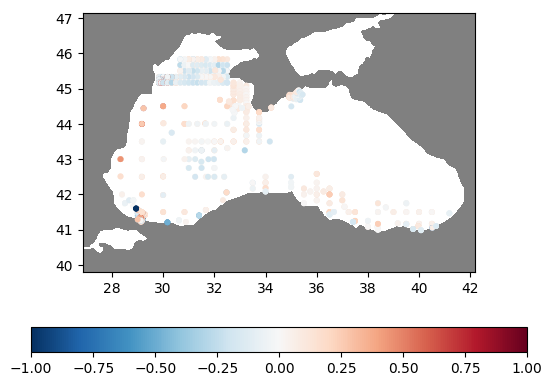

Number of data points: 1378

In [25]:
sel = (obsdepth .<  50) .& (Dates.month.(obstime) .== 1)
print("Number of data points: $(sum(sel))")
contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
scatter(obslon[sel],obslat[sel],10,residual[sel]; cmap="RdBu_r")
clim(-1,1)
# compute and set the correct aspect ratio
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca().set_aspect(aspect_ratio)
colorbar(orientation = "horizontal");

## XML metadata

For DIVAnd analysis using SeaDataCloud/EMODnet-Chemistry data, one can create a XML description for the product for Sextant

Name of the project ("SeaDataCloud" or "EMODNET-chemistry")

In [27]:
project = "SeaDataCloud";

Download CDI list

In [28]:
cdilist = "data/CDI-list-export.zip"

if !isfile(cdilist)
   download("http://emodnet-chemistry.maris2.nl/download/export.zip",cdilist)
end

If `ignore_errors` is `false` (default), then a missing CDI will stop the creatation of the XML metadata.

In [29]:
ignore_errors = true

# File name based on the variable (but all spaces are replaced by _)
xmlfilename = "Water_body_$(replace(varname," "=>"_")).4Danl.xml"

"Water_body_Salinity.4Danl.xml"

Uncomment the following line of you are using SeaDataCloud or EMODnet-Chemistry data.

In [30]:
# generate a XML file for Sextant (only for )
#divadoxml(filename,varname,project,cdilist,xmlfilename,
#          ignore_errors = ignore_errors)